# Ligat Ha'al Data Analysis Project

## Overview
This notebook collects and analyzes Israeli Premier League (Ligat Ha'al) data from multiple sources:
- **Wikipedia**: Match results (20 seasons)
- **Transfermarkt**: Attendance statistics by team and season

## Data Pipeline
1. **Environment Setup**: Configure paths and directories
2. **Match Data Collection**: Scrape Wikipedia for match-by-match results
3. **Attendance Data Collection**: Scrape Transfermarkt for stadium attendance
4. **Data Enrichment**: Calculate derived metrics (points, goal difference, etc.)
5. **Analysis & Visualization**: (To be added)

## Project Structure
```
ligat_haal_project/
├── data/
│   ├── raw/              # Original scraped data
│   ├── interim/          # Cleaned/enriched data
│   └── processed/        # Final datasets for analysis
├── notebooks/            # This notebook
└── reports/
    └── figures/          # Visualizations
```

## Requirements
- Python 3.8+
- pandas, requests, beautifulsoup4, lxml
- See `requirements.txt` for full list

---

## Installation (Optional)

Run this cell only if you need to install dependencies in your notebook environment. 

**Recommended**: Use a virtual environment and install from `requirements.txt`:
```bash
pip install -r ../requirements.txt
```

In [1]:
# Optional: install requirements (recommended to use requirements.txt)
# If you need to install dependencies in the notebook environment, uncomment one of the lines below.
# It's better to run these once in your environment or use a virtualenv and install from requirements.txt.
# pip install -r ../requirements.txt
# or (not recommended to run on every notebook execution):
# pip -q install pandas requests python-dateutil python-dotenv


# Environment Setup

This cell sets up all the necessary paths and environment variables for the notebook:
- Defines `ROOT`, `DATA_DIR`, `INTERIM_DIR`, `PROCESSED_DIR`, `FIG_DIR`
- Creates these directories if they don't exist
- Loads API keys from `.env` or `key.env` files (if available)

**Important**: Run this cell first before running any other cells in the notebook.

In [2]:
# === Environment Setup ===
import os
import sys
from pathlib import Path
import requests

# Try to import python-dotenv (optional, for loading .env files)
try:
    from dotenv import load_dotenv
    DOTENV_AVAILABLE = True
except ImportError:
    DOTENV_AVAILABLE = False
    print("ℹ python-dotenv not installed. Environment variables will be loaded from system only.")

# Feature flag: disable API-Sports section by default (we use Wikipedia + Transfermarkt)
USE_APISPORTS = False

# Define project root (parent of notebooks folder)
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if not (ROOT / 'data').exists() and (ROOT.parent / 'data').exists():
    ROOT = ROOT.parent

# Define data directories
DATA_DIR = ROOT / 'data' / 'raw'
INTERIM_DIR = ROOT / 'data' / 'interim'
PROCESSED_DIR = ROOT / 'data' / 'processed'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories if they don't exist
for directory in [DATA_DIR, INTERIM_DIR, PROCESSED_DIR, FIG_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directories configured:")
print(f"  • ROOT: {ROOT}")
print(f"  • DATA_DIR: {DATA_DIR}")
print(f"  • INTERIM_DIR: {INTERIM_DIR}")
print(f"  • PROCESSED_DIR: {PROCESSED_DIR}")
print(f"  • FIG_DIR: {FIG_DIR}")

# Try to load environment variables from .env or key.env files
APISPORTS_KEY = os.getenv('APISPORTS_KEY')

if DOTENV_AVAILABLE and not APISPORTS_KEY:
    # Try multiple locations for .env files
    env_candidates = [
        ROOT / 'notebooks' / 'key.env',
        ROOT / 'notebooks' / '.env',
        ROOT / 'key.env',
        ROOT / '.env',
    ]
    for env_path in env_candidates:
        if env_path.exists():
            load_dotenv(env_path)
            APISPORTS_KEY = os.getenv('APISPORTS_KEY')
            if APISPORTS_KEY:
                print(f"\n✅ Loaded API key from: {env_path}")
                break

# Setup API configuration (only if enabled)
BASE_URL = None
HEADERS = None
api_get = None

if USE_APISPORTS:
    if APISPORTS_KEY:
        BASE_URL = "https://v3.football.api-sports.io"
        HEADERS = {
            'x-apisports-key': APISPORTS_KEY
        }
        
        # Helper function for API calls
        def api_get(endpoint, params=None):
            """Make a GET request to API-Sports."""
            url = f"{BASE_URL}{endpoint}"
            response = requests.get(url, headers=HEADERS, params=params, timeout=30)
            response.raise_for_status()
            return response.json()
        
        print(f"✅ API configured with key: {APISPORTS_KEY[:4]}...{APISPORTS_KEY[-4:]}")
    else:
        print("\nℹ USE_APISPORTS=True but APISPORTS_KEY not found. API features will not work.")
else:
    # Provide a stub so accidental calls are obvious
    def api_get(*args, **kwargs):
        raise RuntimeError("API-Sports is disabled (set USE_APISPORTS=True in Environment Setup to enable)")
    print("\n⏸ API-Sports is disabled by default (USE_APISPORTS=False). Using Wikipedia + Transfermarkt pipeline.")

print("\n🎯 Environment setup complete! You can now run other cells.")

✅ Directories configured:
  • ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project
  • DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw
  • INTERIM_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\interim
  • PROCESSED_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\processed
  • FIG_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\reports\figures

✅ Loaded API key from: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\key.env

⏸ API-Sports is disabled by default (USE_APISPORTS=False). Using Wikipedia + Transfermarkt pipeline.

🎯 Environment setup complete! You can now run other cells.


c:\Users\nitib\dev-lab\ligat_haal_project\.venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# Helpers to make the notebook resilient across machines
from typing import Optional
import random
import time

_USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0 Safari/537.36",
]

def find_repo_root(start: Optional[Path] = None) -> Path:
    """Find project root by walking up until 'data' or '.git' is found; fallback to CWD."""
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

def ensure_environment():
    """Ensure ROOT/DATA_DIR/... exist and are globals, regardless of CWD used by the runner."""
    global ROOT, DATA_DIR, INTERIM_DIR, PROCESSED_DIR, FIG_DIR
    try:
        _ = DATA_DIR  # type: ignore
    except NameError:
        pass
    # Recompute root defensively if paths look missing
    if 'ROOT' not in globals() or not isinstance(ROOT, Path) or not (ROOT / 'data').exists():
        root_guess = find_repo_root(Path.cwd())
        if not (root_guess / 'data').exists() and (root_guess.parent / 'data').exists():
            root_guess = root_guess.parent
        ROOT = root_guess
    # Set directories
    DATA_DIR = ROOT / 'data' / 'raw'
    INTERIM_DIR = ROOT / 'data' / 'interim'
    PROCESSED_DIR = ROOT / 'data' / 'processed'
    FIG_DIR = ROOT / 'reports' / 'figures'
    # Create
    for d in [DATA_DIR, INTERIM_DIR, PROCESSED_DIR, FIG_DIR]:
        d.mkdir(parents=True, exist_ok=True)
    return ROOT, DATA_DIR, INTERIM_DIR, PROCESSED_DIR, FIG_DIR

import requests

def http_get(url: str, headers: Optional[dict] = None, retries: int = 3, timeout: int = 30) -> str:
    """HTTP GET with rotating user-agents and small backoff; returns response text or raises."""
    last_err = None
    sess = requests.Session()
    for attempt in range(1, retries + 1):
        ua = random.choice(_USER_AGENTS)
        hdrs = {"User-Agent": ua, "Accept-Language": "en-US,en;q=0.9"}
        if headers:
            hdrs.update(headers)
        try:
            resp = sess.get(url, headers=hdrs, timeout=timeout)
            resp.raise_for_status()
            return resp.text
        except Exception as e:
            last_err = e
            time.sleep(0.8 * attempt)
    raise last_err  # type: ignore

def save_csv(df: 'pd.DataFrame', path: Path, **to_csv_kwargs):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False, encoding=to_csv_kwargs.get('encoding', 'utf-8-sig'))
    print(f"Saved: {path}")

## Shared Utilities (Environment + HTTP)

This section documents the small, reusable helpers defined in the previous code cell. They make the notebook portable (runs the same on different machines) and robust for web scraping and file saving.

### What’s included
- Rotating User-Agents list (`_USER_AGENTS`)
  - Cycles between several realistic browser strings to reduce scraping blocks.
- `find_repo_root(start: Optional[Path] = None) -> Path`
- `ensure_environment() -> tuple[Path, Path, Path, Path, Path]`
- `http_get(url: str, headers: Optional[dict] = None, retries: int = 3, timeout: int = 30) -> str`
- `save_csv(df: pd.DataFrame, path: Path, **to_csv_kwargs) -> None`

### Function reference

- `find_repo_root(start: Optional[Path] = None) -> Path`
  - Purpose: Locate the project root by walking up folders until one contains `data/`, `.git/`, or `notebooks/`.
  - Input: Optional starting `Path` (defaults to current working directory).
  - Returns: A `Path` pointing to the inferred project root (falls back to CWD if nothing is found within ~6 levels).
  - Notes: Helps when the notebook is launched from different folders/IDE contexts.

- `ensure_environment()`
  - Purpose: Initialize and expose core directories as globals so paths work anywhere.
  - Creates/sets globals: 
    - `ROOT` (project root)
    - `DATA_DIR` (raw) → `ROOT/data/raw`
    - `INTERIM_DIR` → `ROOT/data/interim`
    - `PROCESSED_DIR` → `ROOT/data/processed`
    - `FIG_DIR` → `ROOT/reports/figures`
  - Behavior: If `ROOT` is missing or wrong, it re-detects via `find_repo_root`. Ensures all folders exist.
  - Returns: `(ROOT, DATA_DIR, INTERIM_DIR, PROCESSED_DIR, FIG_DIR)`.
  - Idempotent: Safe to call multiple times.

- `http_get(url: str, headers: Optional[dict] = None, retries: int = 3, timeout: int = 30) -> str`
  - Purpose: Resilient HTTP GET wrapper.
  - Behavior:
    - Rotates a realistic `User-Agent` each attempt.
    - Allows extra headers to be merged in (e.g., cookies, referer).
    - Retries on failure with a small incremental backoff.
  - Returns: `resp.text` on success.
  - Errors: Raises the last exception after all retries fail.
  - Use this instead of `requests.get` directly for scraping reliability.

- `save_csv(df: pd.DataFrame, path: Path, **to_csv_kwargs)`
  - Purpose: Save a DataFrame to CSV with safe defaults.
  - Behavior: Ensures the parent folder exists; writes UTF‑8 with BOM (`utf-8-sig`) by default so Excel reads Hebrew/Unicode correctly.
  - Returns: `None` (prints a confirmation with the saved path).

### Quick examples
```python
# 1) Initialize folders (safe to call once near the top)
ensure_environment()

# 2) Fetch HTML with retries and rotating User-Agent
html = http_get("https://en.wikipedia.org/wiki/Ligat_Ha%27al")

# 3) Save any DataFrame safely (folders auto-created, encoding friendly for Excel)
# df = pd.DataFrame({"a": [1,2,3]})
# save_csv(df, INTERIM_DIR / "example.csv")
```

Tips:
- If a path-related cell fails after moving the project, call `ensure_environment()` again.
- Prefer `http_get` over raw `requests` to avoid transient scraping issues.
- Use `save_csv` to avoid encoding surprises when opening files in Excel.


## Step 2: Enrich Match Data (2016/17 Example)

This cell demonstrates how to enrich raw match data with calculated metrics:
- **Goal difference**: home_goals - away_goals
- **Match result**: H (home win), A (away win), D (draw)
- **Points**: 3 for win, 1 for draw, 0 for loss
- **One-sided flag**: Matches with goal difference ≥ 3

**Input**: `data/raw/matches_2016_17_ligat_haal_wikipedia.csv`  
**Output**: `data/interim/matches_2016_17_ligat_haal_enriched.csv`

In [4]:
# ...existing code...
# Enrich Wikipedia match-by-match table (robust detection + optional auto-scrape)
import pandas as pd
from pathlib import Path
import re

# Ensure environment and paths are set
ensure_environment()

# Output path
out_path = INTERIM_DIR / "matches_2016_17_ligat_haal_enriched.csv"

# Preferred input filename
preferred = DATA_DIR / "matches_2016_17_ligat_haal_wikipedia.csv"
matches_csv = None

if preferred.exists():
    matches_csv = preferred
else:
    # Search for likely candidates in data/raw (and recursively as fallback)
    candidates = []
    candidates += list(DATA_DIR.glob("matches_2016*.csv"))
    candidates += list(DATA_DIR.glob("matches_*2016*.csv"))
    candidates += list(DATA_DIR.glob("matches_*ligat*2016*.csv"))
    candidates += list(DATA_DIR.glob("matches_all_seasons*.csv"))
    candidates += list(DATA_DIR.rglob("matches*.csv"))

    # Deduplicate and prefer files that contain 2016/2017 or all_seasons
    seen = {}
    for p in candidates:
        try:
            seen[p.resolve()] = p
        except Exception:
            seen[p] = p
    candidates = list(seen.values())

    def score(p: Path):
        name = p.name.lower()
        s = 10
        if "2016" in name and "2017" in name: s -= 6
        if "2016" in name and "17" in name: s -= 5
        if "2016" in name: s -= 4
        if "all_seasons" in name: s -= 3
        if "ligat" in name: s -= 1
        return (s, len(name), str(p))

    candidates = sorted(candidates, key=score)

    if candidates:
        matches_csv = candidates[0]
        print(f"Detected matches CSV: {matches_csv}")
    else:
        # Attempt to auto-scrape 2016/17 from Wikipedia as a last resort
        print(f"Matches CSV not found in {DATA_DIR}. Attempting to scrape 2016/17 from Wikipedia...")
        try:
            from bs4 import BeautifulSoup
            url = "https://en.wikipedia.org/wiki/2016%E2%80%9317_Israeli_Premier_League"
            html = http_get(url)
            soup = BeautifulSoup(html, "html.parser")


            results_table = None
            for table in soup.find_all("table", class_="wikitable"):
                first_row = table.find("tr")
                if first_row:
                    first_cell = first_row.find("th")
                    if first_cell and ("Home \\ Away" in first_cell.text or "Home / Away" in first_cell.text):
                        results_table = table
                        break
            if not results_table:
                raise RuntimeError("Could not find results matrix table on Wikipedia page.")

            rows = results_table.find_all("tr")
            team_names = [td.get_text(strip=True) for td in rows[0].find_all("th")][1:]

            matches = []
            for row in rows[1:]:
                cells = row.find_all(["th", "td"])
                home_team = cells[0].get_text(strip=True)
                for j, cell in enumerate(cells[1:]):
                    away_team = team_names[j]
                    score = cell.get_text(strip=True)
                    if re.match(r"^\d+\s*[–-]\s*\d+$", score):
                        home_goals, away_goals = re.split(r"[–-]", score)
                        matches.append({
                            "season": "2016/17",
                            "home_team": home_team,
                            "away_team": away_team,
                            "home_goals": int(home_goals.strip()),
                            "away_goals": int(away_goals.strip())
                        })

            if not matches:
                raise RuntimeError("No matches parsed from Wikipedia.")

            df_autoscrape = pd.DataFrame(matches, columns=[
                "season", "home_team", "away_team", "home_goals", "away_goals"
            ])
            save_csv(df_autoscrape, DATA_DIR / "matches_2016_17_ligat_haal_wikipedia.csv")
            matches_csv = DATA_DIR / "matches_2016_17_ligat_haal_wikipedia.csv"
            print("✅ Created matches CSV via auto-scrape.")
        except Exception as e:
            raise FileNotFoundError(
                f"Matches CSV not found and auto-scrape failed: {e}\n"
                f"Tried to create: {DATA_DIR / 'matches_2016_17_ligat_haal_wikipedia.csv'}\n"
                "Run the scraping cells manually or place the CSV in data/raw/."
            ) from e

# Load dataframe
print(f"Loading matches from: {matches_csv}")
df = pd.read_csv(matches_csv)

# Ensure numeric goal columns (in case of strings)
for col in ["home_goals", "away_goals"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Derived columns
df["goal_diff"] = df["home_goals"] - df["away_goals"]
df["result"] = df["goal_diff"].apply(lambda x: "H" if x > 0 else ("A" if x < 0 else "D"))
df["home_points"] = df["result"].map({"H": 3, "D": 1, "A": 0})
df["away_points"] = df["result"].map({"A": 3, "D": 1, "H": 0})

# Optional: simple flag for one-sided results
df["one_sided"] = (df["goal_diff"].abs() >= 3).astype(int)

# Reorder/keep columns defensively
cols = [
    "season", "home_team", "away_team",
    "home_goals", "away_goals", "goal_diff", "result",
    "home_points", "away_points", "one_sided"
]
ordered = [c for c in cols if c in df.columns]
df = df[ordered]

# Save enriched file
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"Saved enriched matches to: {out_path} | rows: {len(df)}")
display(df.head(10))
# ...existing code...

Loading matches from: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2016_17_ligat_haal_wikipedia.csv
Saved enriched matches to: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\interim\matches_2016_17_ligat_haal_enriched.csv | rows: 182


,season,home_team,away_team,home_goals,away_goals,goal_diff,result,home_points,away_points,one_sided
0,2016/17,F.C. Ashdod,Beitar Jerusalem,0,0,0,D,1,1,0
1,2016/17,F.C. Ashdod,Bnei Sakhnin,1,1,0,D,1,1,0
2,2016/17,F.C. Ashdod,Bnei Yehuda,2,2,0,D,1,1,0
3,2016/17,F.C. Ashdod,Hapoel Ashkelon,1,0,1,H,3,0,0
4,2016/17,F.C. Ashdod,Hapoel Be'er Sheva,0,1,-1,A,0,3,0
5,2016/17,F.C. Ashdod,Hapoel Haifa,1,3,-2,A,0,3,0
6,2016/17,F.C. Ashdod,Hapoel Kfar Saba,0,0,0,D,1,1,0
7,2016/17,F.C. Ashdod,Hapoel Ra'anana,0,1,-1,A,0,3,0
8,2016/17,F.C. Ashdod,Hapoel Tel Aviv,1,0,1,H,3,0,0
9,2016/17,F.C. Ashdod,Ironi Kiryat Shmona,0,0,0,D,1,1,0


## Step 3: Advanced Enrichment (2022/23 Example)

This cell shows a more comprehensive enrichment process with:
- **Phase parsing**: Extract "regular", "championship", or "relegation" from round names
- **Round number**: Extract numeric round from strings like "Regular Season - 1"
- **Goal difference, results, points**: Same as Step 2
- **One-sided matches**: Flag matches with |goal_diff| ≥ 3
- **Column cleanup**: Remove irrelevant API-specific columns

**Input**: `data/raw/matches_2022_23_ligat_haal.csv` (if using API-Sports)  
**Output**: `data/interim/matches_2022_23_enriched.csv`

**Note**: This cell is for API-Sports data. For Wikipedia data, use the simpler enrichment in Step 2.

In [5]:
# === העשרת הטבלה + ניקוי עמודות מיותרות ===
# Note: This cell is for API-Sports data (2022/23). 
# If you're using Wikipedia data, skip this cell and use the enrichment cell above instead.
import re
import pandas as pd

# Ensure environment is set up
ensure_environment()

in_path  = DATA_DIR / "matches_2022_23_ligat_haal.csv"   # שנה לקובץ שלך
out_path = INTERIM_DIR / "matches_2022_23_enriched.csv"

# Check if file exists before attempting to process
if not in_path.exists():
    print(f"ℹ Skipping 2022/23 enrichment - input file not found: {in_path}")
    print(f"  This cell is for API-Sports data. If you're using Wikipedia data,")
    print(f"  your enriched file is already created by the enrichment cell above.")
else:
    df = pd.read_csv(in_path)

    # --- עמודות עזר ---
    # 1) שנה מספרית לפתיחת העונה
    #df["season_year"] = df["season"].str.slice(0,4).astype(int)

    # 2) מספר מחזור ו-phase
    def parse_round(r):
        # דוגמאות: "Regular Season - 1", "Championship Round - 5"
        if pd.isna(r):
            return (None, None)
        r = str(r)
        m = re.search(r"(Regular|Championship|Relegation).*?(\d+)", r, flags=re.I)
        phase = None
        if "regular" in r.lower():      phase = "regular"
        elif "championship" in r.lower(): phase = "championship"
        elif "relegation" in r.lower():   phase = "relegation"
        round_num = int(m.group(2)) if m else None
        return (phase, round_num)

    tmp = df["round"].apply(parse_round).tolist()
    df["phase"] = [t[0] for t in tmp]
    df["round_num"] = [t[1] for t in tmp]

    # 3) הפרש שערים, תוצאה, נקודות
    df["goal_diff"] = df["home_goals"] - df["away_goals"]
    df["result"] = df["goal_diff"].apply(lambda x: "H" if x>0 else ("A" if x<0 else "D"))
    df["home_points"] = df["result"].map({"H":3, "D":1, "A":0})
    df["away_points"] = df["result"].map({"H":0, "D":1, "A":3})

    # 4) דגל משחק חד-צדדי (למשל |GD|>=3)
    df["one_sided"] = (df["goal_diff"].abs() >= 3).astype(int)

    # 5) עמודות לא רלוונטיות להסרה (כפי שביקשת)
    drop_cols = ["league_id","league_name","fixture_id"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    # 6) סדר עמודות נוח
    cols = [
        "season","season_year","date","phase","round_num","stage",
        "home_team","away_team","home_goals","away_goals","goal_diff","result",
        "home_points","away_points","one_sided","venue","referee"
    ]
    df = df[[c for c in cols if c in df.columns]]

    save_csv(df, out_path)
    print("נשמר:", out_path, "| שורות:", len(df))
    display(df.head(10))


ℹ Skipping 2022/23 enrichment - input file not found: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2022_23_ligat_haal.csv
  This cell is for API-Sports data. If you're using Wikipedia data,
  your enriched file is already created by the enrichment cell above.


## Step 4: Scrape League Table from Wikipedia (2016/17)

This cell demonstrates how to fetch a league standings table from Wikipedia using pandas' `read_html()`.

**What it does**:
- Fetches the 2016/17 Israeli Premier League Wikipedia page
- Uses `read_html()` to automatically parse HTML tables
- Identifies the league table by looking for typical columns (Team, Points, etc.)
- Saves the standings to CSV

**Output**: `data/raw/ligat_haal_2016_17_wikipedia.csv`

**Note**: This gives you final standings, not match-by-match data. For match data, see the next cells.

In [6]:
# Scrape 2016/17 Ligat Ha'al league table from Wikipedia and save as CSV
# Use requests with a browser User-Agent to avoid HTTP 403 from the site
import re

url = "https://en.wikipedia.org/wiki/2016%E2%80%9317_Israeli_Premier_League"
resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117 Safari/537.36"}, timeout=30)
resp.raise_for_status()

tables = pd.read_html(resp.text)

# Find the main league table (usually the first or second table)
def find_league_table(tables):
    for df in tables:
        # Look for columns typical of league tables
        cols = [c.lower() for c in df.columns.astype(str)]
        if any(re.search(r"team|club", c) for c in cols) and any(re.search(r"pts|points", c) for c in cols):
            return df
    return tables[0]  # fallback

league_df = find_league_table(tables)
print("Columns:", league_df.columns.tolist())
print("Rows:", len(league_df))

# Save to CSV in data/raw/
csv_path = Path(DATA_DIR) / "ligat_haal_2016_17_wikipedia.csv"
league_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"Saved Wikipedia league table to: {csv_path}")
league_df.head()

C:\Users\nitib\AppData\Local\Temp\ipykernel_27476\2324587512.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


Columns: ['Pos', 'Team', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Qualification or relegation']
Rows: 14
Saved Wikipedia league table to: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\ligat_haal_2016_17_wikipedia.csv


,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,1,Hapoel Be'er Sheva,26,18,5,3,54,13,+41,59,Qualification for the Championship round
1,2,Maccabi Tel Aviv,26,17,5,4,45,19,+26,56,Qualification for the Championship round
2,3,Maccabi Petah Tikva,26,13,9,4,36,23,+13,48,Qualification for the Championship round
3,4,Beitar Jerusalem,26,10,10,6,34,27,+7,40,Qualification for the Championship round
4,5,Bnei Sakhnin,26,10,9,7,26,26,0,39,Qualification for the Championship round


## Step 5: Scrape Match-by-Match Results from Wikipedia (2016/17)

This cell extracts individual match results from Wikipedia's results matrix table.

**How it works**:
1. Fetches the Wikipedia page for 2016/17 season
2. Finds the results matrix table (grid showing Home vs Away results)
3. Parses each cell to extract scores (e.g., "2–1")
4. Creates one row per match with home/away teams and goals
5. Calculates derived metrics (goal_diff, result, points)

**Output**: `data/raw/matches_2016_17_ligat_haal_wikipedia.csv`

**Derived columns**:
- `goal_diff`: home_goals - away_goals
- `result`: H (home win), A (away win), D (draw)
- `home_points` / `away_points`: 3 for win, 1 for draw, 0 for loss

In [7]:
# Scrape 2016/17 Ligat Ha'al match-by-match results from Wikipedia and save as CSV
import pandas as pd
from bs4 import BeautifulSoup
from pathlib import Path
import re

# Ensure environment/paths
ensure_environment()

# Fetch and parse the Wikipedia page
url = "https://en.wikipedia.org/wiki/2016%E2%80%9317_Israeli_Premier_League"
html = http_get(url)
soup = BeautifulSoup(html, "html.parser")

# Find the results matrix table by checking the first header cell
results_table = None
for table in soup.find_all("table", class_="wikitable"):
    first_row = table.find("tr")
    if first_row:
        first_cell = first_row.find("th")
        if first_cell and ("Home \\ Away" in first_cell.text or "Home / Away" in first_cell.text):
            results_table = table
            break

if not results_table:
    raise ValueError("Could not find results matrix table on Wikipedia page.")

# Parse teams from the first column and first row
rows = results_table.find_all("tr")
team_names = [td.get_text(strip=True) for td in rows[0].find_all("th")][1:]

# Build match list
matches = []
for i, row in enumerate(rows[1:]):
    cells = row.find_all(["th", "td"])
    home_team = cells[0].get_text(strip=True)
    for j, cell in enumerate(cells[1:]):
        away_team = team_names[j]
        score = cell.get_text(strip=True)
        # Only add if score looks like a result (e.g., '2–1')
        if re.match(r"^\d+\s*[–-]\s*\d+$", score):
            home_goals, away_goals = re.split(r"[–-]", score)
            matches.append({
                "season": "2016/17",
                "home_team": home_team,
                "away_team": away_team,
                "home_goals": int(home_goals.strip()),
                "away_goals": int(away_goals.strip()),
                "score": score
            })

# Convert to DataFrame and save
df = pd.DataFrame(matches)

# Add simple derived columns
df['goal_diff'] = df['home_goals'] - df['away_goals']
df['result'] = df['goal_diff'].apply(lambda x: "H" if x>0 else ("A" if x<0 else "D"))
df['home_points'] = df['result'].map({"H":3, "D":1, "A":0}).fillna(0).astype(int)
df['away_points'] = df['result'].map({"A":3, "D":1, "H":0}).fillna(0).astype(int)

# Select and order columns
keep_cols = ['season', 'home_team', 'away_team', 'home_goals', 'away_goals', 
             'goal_diff', 'result', 'home_points', 'away_points']
df = df[keep_cols]

# Save to CSV
csv_path = Path(DATA_DIR) / "matches_2016_17_ligat_haal_wikipedia.csv"
save_csv(df, csv_path)
print(f"Total matches: {len(df)}")
df.head()

Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2016_17_ligat_haal_wikipedia.csv
Total matches: 182


,season,home_team,away_team,home_goals,away_goals,goal_diff,result,home_points,away_points
0,2016/17,F.C. Ashdod,BEI,0,0,0,D,1,1
1,2016/17,F.C. Ashdod,BnS,1,1,0,D,1,1
2,2016/17,F.C. Ashdod,BnY,2,2,0,D,1,1
3,2016/17,F.C. Ashdod,HAS,1,0,1,H,3,0
4,2016/17,F.C. Ashdod,HBS,0,1,-1,A,0,3


## Step 6: Multi-Season Wikipedia Scraper (Last 20 Seasons)

This cell automates the match scraping process across multiple seasons.

**What it does**:
1. Calculates the last 20 seasons dynamically (based on current date)
2. For each season:
   - Fetches the Wikipedia page
   - Extracts the results matrix
   - Parses match-by-match data
   - Saves individual season CSV
3. Combines all seasons into one master file

**Outputs**:
- Per-season: `data/raw/matches_YYYY_YY_ligat_haal_wikipedia.csv`
- Combined: `data/raw/matches_all_seasons_ligat_haal_wikipedia.csv`

**Features**:
- Polite scraping with 1-second delays between requests
- Error handling for missing/changed pages
- Progress tracking with ✓/❌ indicators
- Season summary report

In [8]:
# Scrape multiple seasons of Ligat Ha'al from Wikipedia
import pandas as pd
from bs4 import BeautifulSoup
from pathlib import Path
import re
import time
from datetime import datetime

ensure_environment()

def scrape_season(season_year):
    """
    Scrape a single season's matches from Wikipedia.
    season_year: starting year (e.g., 2016 for 2016/17 season)
    """
    season_str = f"{season_year}/{str(season_year+1)[-2:]}"
    url = f"https://en.wikipedia.org/wiki/{season_year}%E2%80%93{str(season_year+1)[-2:]}_Israeli_Premier_League"
    
    print(f"Fetching {season_str}... ", end="", flush=True)
    try:
        html = http_get(url)
        soup = BeautifulSoup(html, "html.parser")

        
        # Find results matrix
        results_table = None
        for table in soup.find_all("table", class_="wikitable"):
            first_row = table.find("tr")
            if first_row:
                first_cell = first_row.find("th")
                if first_cell and ("Home \\ Away" in first_cell.text or "Home / Away" in first_cell.text):
                    results_table = table
                    break
        
        if not results_table:
            print("❌ (no results matrix)")
            return None
            
        # Parse teams and build matches
        rows = results_table.find_all("tr")
        team_names = [td.get_text(strip=True) for td in rows[0].find_all("th")][1:]
        
        matches = []
        for i, row in enumerate(rows[1:]):
            cells = row.find_all(["th", "td"])
            home_team = cells[0].get_text(strip=True)
            for j, cell in enumerate(cells[1:]):
                away_team = team_names[j]
                score = cell.get_text(strip=True)
                if re.match(r"^\d+\s*[–-]\s*\d+$", score):
                    home_goals, away_goals = re.split(r"[–-]", score)
                    matches.append({
                        "season": season_str,
                        "season_year": season_year,
                        "home_team": home_team,
                        "away_team": away_team,
                        "home_goals": int(home_goals.strip()),
                        "away_goals": int(away_goals.strip())
                    })
        
        if not matches:
            print("❌ (no matches found)")
            return None
            
        # Convert to DataFrame and add derived columns
        df = pd.DataFrame(matches)
        df['goal_diff'] = df['home_goals'] - df['away_goals']
        df['result'] = df['goal_diff'].apply(lambda x: "H" if x>0 else ("A" if x<0 else "D"))
        df['home_points'] = df['result'].map({"H":3, "D":1, "A":0}).fillna(0).astype(int)
        df['away_points'] = df['result'].map({"A":3, "D":1, "H":0}).fillna(0).astype(int)
        
        # Select and order columns
        keep_cols = ['season', 'season_year', 'home_team', 'away_team', 'home_goals', 
                     'away_goals', 'goal_diff', 'result', 'home_points', 'away_points']
        df = df[keep_cols]
        
        print(f"✓ ({len(df)} matches)")
        return df
        
    except Exception as e:
        print(f"❌ ({str(e)[:50]}...)")
        return None

# List of seasons to scrape (last 20 seasons)
current_year = datetime.now().year
if datetime.now().month < 8:  # If before August, last season started in previous year
    current_year -= 1
seasons = list(range(current_year - 19, current_year + 1))

print(f"Scraping {len(seasons)} seasons from Wikipedia ({seasons[0]}/{str(seasons[0]+1)[-2:]} to {seasons[-1]}/{str(seasons[-1]+1)[-2:]})...")

# Scrape each season
all_matches = []
for season_year in seasons:
    df = scrape_season(season_year)
    if df is not None:
        # Save individual season
        season_path = DATA_DIR / f"matches_{season_year}_{str(season_year+1)[-2:]}_ligat_haal_wikipedia.csv"
        save_csv(df, season_path)
        all_matches.append(df)
    time.sleep(1)  # Be nice to Wikipedia

if all_matches:
    # Combine all seasons
    combined_df = pd.concat(all_matches, ignore_index=True)
    combined_path = DATA_DIR / "matches_all_seasons_ligat_haal_wikipedia.csv"
    save_csv(combined_df, combined_path)
    
    print("\nSummary:")
    print(f"- Successfully scraped {len(all_matches)} seasons")
    print(f"- Total matches: {len(combined_df)}")
    print(f"\nMatches per season:")
    season_counts = combined_df.groupby('season').size().sort_index()
    for season, count in season_counts.items():
        print(f"  • {season}: {count:3d} matches")
    print(f"\nAll matches saved to: {combined_path}")
    display(combined_df.head())

Scraping 20 seasons from Wikipedia (2006/07 to 2025/26)...
Fetching 2006/07... ✓ (132 matches)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2006_07_ligat_haal_wikipedia.csv
✓ (132 matches)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2006_07_ligat_haal_wikipedia.csv
Fetching 2007/08... Fetching 2007/08... ✓ (132 matches)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2007_08_ligat_haal_wikipedia.csv
✓ (132 matches)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2007_08_ligat_haal_wikipedia.csv
Fetching 2008/09... Fetching 2008/09... ✓ (132 matches)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2008_09_ligat_haal_wikipedia.csv
✓ (132 matches)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2008_09_ligat_haal_wikipedia.csv
Fetching 2009/10... Fetching 2009/10.

,season,season_year,home_team,away_team,home_goals,away_goals,goal_diff,result,home_points,away_points
0,2006/07,2006,Beitar Jerusalem,BnY,0,0,0,D,1,1
1,2006/07,2006,Beitar Jerusalem,ASH,2,0,2,H,3,0
2,2006/07,2006,Beitar Jerusalem,HAK,0,0,0,D,1,1
3,2006/07,2006,Beitar Jerusalem,HKS,2,0,2,H,3,0
4,2006/07,2006,Beitar Jerusalem,HPT,2,0,2,H,3,0


## Step 7: Scrape Attendance Data from Transfermarkt (Single Season)

This cell demonstrates scraping **actual attendance statistics** from Transfermarkt.

**Why Transfermarkt?**
- Wikipedia only shows stadium capacity (max seats), not actual attendance
- Transfermarkt provides real match attendance data aggregated by team per season

**Data collected per team**:
- `team`: Club name
- `average_attendance`: Average fans per home match
- `total_attendance`: Total fans across all home matches
- `stadium_capacity`: Maximum stadium capacity
- `utilization_pct`: Calculated as (average / capacity × 100)

**How utilization_pct is calculated**:
Since Transfermarkt doesn't provide a percentage column, we calculate it:
```
utilization_pct = (average_attendance / stadium_capacity) × 100
```

**Example output (2016/17)**:
- Hapoel Beer Sheva: 89.7% utilization (nearly full!)
- Ironi Kiryat Shmona: 10.8% utilization (mostly empty)

**Output**: `data/raw/attendance_YYYY_YY_ligat_haal_transfermarkt.csv`

**Source**: [Transfermarkt - Ligat Ha'al Attendance](https://www.transfermarkt.com/ligat-haal/besucherzahlen/wettbewerb/ISR1)

In [9]:
# Scrape attendance data from Transfermarkt for 2016/17 season (robust parser with header mapping)
import pandas as pd
from bs4 import BeautifulSoup
from pathlib import Path
import re
from typing import Optional, List

# Ensure environment for both machines
ensure_environment()

def _to_int(text: Optional[str]) -> Optional[int]:
    if text is None:
        return None
    s = str(text)
    s = s.replace('\xa0', ' ').strip()
    # remove everything that's not a digit
    digits = re.sub(r"[^0-9]", "", s)
    return int(digits) if digits else None

def _extract_club_from_cell(td) -> Optional[str]:
    # Prefer anchors that link to a club page
    a = td.find('a', href=re.compile(r"/verein/|/club/", re.I))
    if a and a.get_text(strip=True):
        return a.get_text(strip=True)
    # Try image alt text (sometimes club crest has alt)
    img = td.find('img')
    if img and img.get('alt'):
        return img.get('alt').strip()
    # Sometimes the club appears in parentheses after stadium name
    txt = td.get_text(" ", strip=True)
    m = re.search(r"\(([^\)]+)\)$", txt)
    if m:
        return m.group(1).strip()
    # Fallback to text (stadium) if nothing else
    return txt

def scrape_transfermarkt_attendance(season_year: int) -> Optional[pd.DataFrame]:
    """
    Scrape attendance data from Transfermarkt for a specific season.
    season_year: starting year (e.g., 2016 for 2016/17 season)
    Returns: DataFrame with team, average_attendance, total_attendance, stadium_capacity, utilization_pct
    
    Note: utilization_pct is calculated as (average_attendance / stadium_capacity * 100)
    since Transfermarkt doesn't always provide this column directly.
    """
    season_str = f"{season_year}/{str(season_year+1)[-2:]}"
    url = f"https://www.transfermarkt.com/ligat-haal/besucherzahlen/wettbewerb/ISR1/saison_id/{season_year}"

    print(f"Fetching {season_str} from Transfermarkt... ", end="", flush=True)

    try:
        html = http_get(url)
        soup = BeautifulSoup(html, "html.parser")


        attendance_table = soup.find("table", class_="items")
        if not attendance_table:
            print("❌ (no attendance table found)")
            return None

        thead = attendance_table.find("thead")
        header_cells = []
        if thead:
            header_cells = [th.get_text(" ", strip=True).lower() for th in thead.find_all("th")]
        tbody = attendance_table.find("tbody") or attendance_table
        rows = tbody.find_all("tr")

        # Build a name->index mapping from header text
        header_index = {name: idx for idx, name in enumerate(header_cells)}
        def find_col_index(key_words: List[str]) -> Optional[int]:
            for name, idx in header_index.items():
                if any(kw in name for kw in key_words):
                    return idx
            return None

        idx_rank = find_col_index(["#"])  # not used
        idx_stadium = find_col_index(["stadium", "ground", "venue"]) or 1
        idx_capacity = find_col_index(["capacity", "kapaz"]) or 2
        idx_total = find_col_index(["spectators", "gesamt", "total"]) or 3
        idx_avg = find_col_index(["average", "durchschnitt", "ø"]) or 4
        idx_pct = find_col_index(["%", "percent", "auslast"])  # optional (usually not present)

        data: List[dict] = []
        for tr in rows:
            # Skip header or spacer rows
            if tr.find("th"):
                continue
            tds = tr.find_all("td")
            if not tds:
                continue

            # Compute offset if there are unlabeled extra columns (e.g., crest)
            offset = 0
            if header_cells and len(tds) != len(header_cells):
                # assume extra leading cells
                offset = max(0, len(tds) - len(header_cells))

            def td_at(index: int):
                i = index + offset
                return tds[i] if 0 <= i < len(tds) else None

            td_stadium = td_at(idx_stadium)
            td_capacity = td_at(idx_capacity)
            td_total = td_at(idx_total)
            td_avg = td_at(idx_avg)
            td_pct = td_at(idx_pct) if idx_pct is not None else None

            if not td_stadium:
                continue

            club = _extract_club_from_cell(td_stadium)
            capacity = _to_int(td_capacity.get_text()) if td_capacity else None
            total = _to_int(td_total.get_text()) if td_total else None
            avg = _to_int(td_avg.get_text()) if td_avg else None
            
            # Try to parse utilization if column exists (rarely the case)
            util = None
            if td_pct:
                util_text = td_pct.get_text(strip=True)
                util_digits = re.sub(r"[^0-9.,]", "", util_text).replace(',', '.')
                try:
                    util = float(util_digits) if util_digits else None
                except:
                    util = None

            # Filter out aggregate or empty rows
            if club and (avg is not None or total is not None or capacity is not None):
                # Ignore summary rows
                if str(club).lower() in {"total", "sum", "gesamt"}:
                    continue
                data.append({
                    "season": season_str,
                    "season_year": season_year,
                    "team": club,
                    "average_attendance": avg,
                    "total_attendance": total,
                    "stadium_capacity": capacity,
                    "utilization_pct": util,  # Will be recalculated below
                })

        if not data:
            print("❌ (parsed 0 usable rows)")
            return None

        df = pd.DataFrame(data)
        
        # Calculate utilization_pct from capacity and average if not already present
        if 'utilization_pct' in df.columns and df['utilization_pct'].isna().all():
            df['utilization_pct'] = df.apply(
                lambda row: round((row['average_attendance'] / row['stadium_capacity'] * 100), 1) 
                if pd.notna(row['average_attendance']) and pd.notna(row['stadium_capacity']) and row['stadium_capacity'] > 0
                else None,
                axis=1
            )
        
        # Drop duplicates that may arise from multi-rows in table
        df = df.drop_duplicates(subset=["team"]).reset_index(drop=True)
        print(f"✓ ({len(df)} teams)")
        return df

    except Exception as e:
        print(f"❌ ({str(e)[:120]})")
        return None

# Test with 2016/17 season
season_year = 2016
df = scrape_transfermarkt_attendance(season_year)

if df is not None:
    # Save to CSV
    csv_path = DATA_DIR / f"attendance_{season_year}_{str(season_year+1)[-2:]}_ligat_haal_transfermarkt.csv"
    save_csv(df, csv_path)

    print(f"\nPreview:")
    display(df.head(20))

    if 'average_attendance' in df.columns and df['average_attendance'].notna().any():
        print(f"\nAttendance Summary for {season_year}/{str(season_year+1)[-2:]}:")
        print(f"  • Teams: {len(df)}")
        print(f"  • Average attendance (mean): {df['average_attendance'].mean():.0f}")
        print(f"  • Highest: {df.loc[df['average_attendance'].idxmax(), 'team']} ({df['average_attendance'].max():.0f})")
        print(f"  • Lowest: {df.loc[df['average_attendance'].idxmin(), 'team']} ({df['average_attendance'].min():.0f})")
        
        if 'utilization_pct' in df.columns and df['utilization_pct'].notna().any():
            print(f"\nStadium Utilization:")
            print(f"  • Average utilization: {df['utilization_pct'].mean():.1f}%")
            print(f"  • Highest: {df.loc[df['utilization_pct'].idxmax(), 'team']} ({df['utilization_pct'].max():.1f}%)")
            print(f"  • Lowest: {df.loc[df['utilization_pct'].idxmin(), 'team']} ({df['utilization_pct'].min():.1f}%)")
else:
    print("\n⚠ Could not retrieve attendance data from Transfermarkt.")
    print("Possible reasons:")
    print("  • Transfermarkt may not have data for this season")
    print("  • Website structure may have changed or is blocking bots")
    print("  • Network/access issue")
    print("\nTip: Try running again or switch to a fallback source (worldfootball.net)")

Fetching 2016/17 from Transfermarkt... 

✓ (14 teams)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\attendance_2016_17_ligat_haal_transfermarkt.csv

Preview:


,season,season_year,team,average_attendance,total_attendance,stadium_capacity,utilization_pct
0,2016/17,2016,Maccabi Haifa,21891,284587,30780,71.1
1,2016/17,2016,Hapoel Beer Sheva,14467,188072,16126,89.7
2,2016/17,2016,Maccabi Tel Aviv,9529,123871,29150,32.7
3,2016/17,2016,Beitar Jerusalem,8192,106500,33500,24.5
4,2016/17,2016,Hapoel Tel Aviv,7900,102700,29150,27.1
5,2016/17,2016,Hapoel Haifa,4900,63700,30820,15.9
6,2016/17,2016,Maccabi Petah Tikva,3450,44850,11500,30.0
7,2016/17,2016,Bnei Yehuda Tel Aviv,3312,43050,6020,55.0
8,2016/17,2016,Ihud Bnei Sakhnin,3231,42000,8500,38.0
9,2016/17,2016,Hapoel Ashkelon,2785,36210,10000,27.9



Attendance Summary for 2016/17:
  • Teams: 14
  • Average attendance (mean): 6261
  • Highest: Maccabi Haifa (21891)
  • Lowest: Ironi Kiryat Shmona (1492)

Stadium Utilization:
  • Average utilization: 37.3%
  • Highest: Hapoel Beer Sheva (89.7%)
  • Lowest: Ironi Kiryat Shmona (10.8%)


## Step 8: Test Attendance Scraper (2023/24)

Quick validation test on a recent season to ensure the scraper works correctly.

**Output**: `data/raw/attendance_2023_24_ligat_haal_transfermarkt.csv`

In [10]:
# Quick test: scrape 2023/24 season as well
ensure_environment()
season_year = 2023
_df_2023 = scrape_transfermarkt_attendance(season_year)
if _df_2023 is not None:
    _csv_2023 = DATA_DIR / f"attendance_{season_year}_{str(season_year+1)[-2:]}_ligat_haal_transfermarkt.csv"
    save_csv(_df_2023, _csv_2023)
    display(_df_2023.head(20))
else:
    print("Failed to scrape 2023/24 attendance from Transfermarkt.")

Fetching 2023/24 from Transfermarkt... ✓ (14 teams)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\attendance_2023_24_ligat_haal_transfermarkt.csv
✓ (14 teams)
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\attendance_2023_24_ligat_haal_transfermarkt.csv


,season,season_year,team,average_attendance,total_attendance,stadium_capacity,utilization_pct
0,2023/24,2023,Maccabi Tel Aviv,17797,213565,29150,61.1
1,2023/24,2023,Maccabi Haifa,17195,171948,30780,55.9
2,2023/24,2023,Beitar Jerusalem,13166,144830,33500,39.3
3,2023/24,2023,Hapoel Beer Sheva,10169,122024,16126,63.1
4,2023/24,2023,Hapoel Tel Aviv,9186,101049,29150,31.5
5,2023/24,2023,Maccabi Netanya,5844,70127,13610,42.9
6,2023/24,2023,Hapoel Petah Tikva,5524,60759,11500,48.0
7,2023/24,2023,Hapoel Haifa,3869,42559,30820,12.6
8,2023/24,2023,Hapoel Jerusalem,3643,40070,33500,10.9
9,2023/24,2023,Maccabi Petah Tikva,3576,39337,11500,31.1


---

## Next Steps

Now that you have collected match and attendance data, you can:

### 1. Multi-Season Attendance Collection
Create a loop to scrape attendance for all 20 seasons (similar to the Wikipedia multi-season scraper).

### 2. Data Merging
Merge attendance data with match data by `(season, team)` to analyze:
- Home performance vs attendance levels
- Win rate correlation with fan support
- Derby match attendance spikes

### 3. Team Name Normalization
Standardize team names between Wikipedia and Transfermarkt sources for accurate joining.

### 4. Analysis & Visualization
- Time series of attendance trends
- Team performance over multiple seasons
- Home advantage analysis
- Goal-scoring patterns

### 5. Statistical Modeling
- Predict match outcomes based on historical data
- Attendance forecasting
- League position projections

---

**Current Data Available**:
- ✅ Match results: 20 seasons from Wikipedia (`matches_all_seasons_ligat_haal_wikipedia.csv`)
- ✅ Attendance: 2016/17 and 2023/24 from Transfermarkt
- ✅ Enriched data: Calculated metrics (points, goal_diff, results)

**Files Generated**:
```
data/raw/
├── matches_YYYY_YY_ligat_haal_wikipedia.csv (per season)
├── matches_all_seasons_ligat_haal_wikipedia.csv (combined)
├── attendance_2016_17_ligat_haal_transfermarkt.csv
└── attendance_2023_24_ligat_haal_transfermarkt.csv

data/interim/
├── matches_2016_17_ligat_haal_enriched.csv
└── matches_2022_23_enriched.csv
```

## Analysis 1: League Leadership Changes

This section calculates how many times first place changed hands during a season.

**How it works:**
1. Load match data for a specific season
2. Calculate cumulative standings after each matchday
3. Track which team was in first place after each round
4. Count how many times leadership changed

**Data source:** Wikipedia match results (not Transfermarkt - they don't have matchday-by-matchday data)

**Example analysis:** 2016/17 season


### CRITICAL FIX: Team Name Normalization

**Problem discovered:** The Wikipedia results matrix uses:
- Full team names in rows (home teams)
- Abbreviations in columns (away teams)

This creates duplicate teams (28 instead of 14) and incorrect statistics!

**Solution:** Create a mapping to normalize all team names to their full versions.

In [11]:
# Team Name Mapping - Normalizes abbreviations and variants to full names
# This mapping consolidates Wikipedia's inconsistent team naming across 20 seasons

TEAM_NAME_MAP = {
    # Abbreviations to full names
    'ASH': 'F.C. Ashdod',
    'BEI': 'Beitar Jerusalem',
    'BnS': 'Bnei Sakhnin',
    'BnY': 'Bnei Yehuda',
    'HAS': 'Hapoel Ashkelon',
    'HBS': "Hapoel Be'er Sheva",
    'HHA': 'Hapoel Haifa',
    'HKS': 'Hapoel Kfar Saba',
    'HRA': "Hapoel Ra'anana",
    'HTA': 'Hapoel Tel Aviv',
    'IKS': 'Ironi Kiryat Shmona',
    'MHA': 'Maccabi Haifa',
    'MPT': 'Maccabi Petah Tikva',
    'MTA': 'Maccabi Tel Aviv',
    'HPT': 'Hapoel Petah Tikva',
    'HRG': 'Hapoel Ramat Gan',
    'HRH': 'Hapoel Ramat HaSharon',
    'HRL': 'Rishon LeZion',
    'MAN': 'Maccabi Ahi Nazareth',
    'MBR': 'Maccabi Bnei Reineh',
    'SNZ': 'Sektzia Ness Ziona',
    'HAK': 'Hapoel Acre',
    'MHE': 'Maccabi Herzliya',
    'MNE': 'Maccabi Netanya',
    'HAR': 'Hapoel Raanana',
    'HAC': 'Hapoel Acre',
    'IRH': 'Ironi Ramat HaSharon',
    'HAH': 'Hapoel Hadera',
    'NES': 'Ness Ziona',
    'HJE': 'Hapoel Jerusalem',
    'HNG': 'Hapoel Nof HaGalil',
    'ITI': 'Ironi Tiberias',
    
    # Name variants to canonical names
    'Ashdod': 'F.C. Ashdod',
    'F.C. Ironi Ashdod': 'F.C. Ashdod',
    'Ness Ziona': 'Sektzia Ness Ziona',
    'Ironi Nir Ramat HaSharon': 'Ironi Ramat HaSharon',
    'Hakoah Amidar Ramat Gan': 'Hapoel Ramat Gan',
    'Hapoel Rishon LeZion': 'Rishon LeZion',
    'Hapoel Raanana': "Hapoel Ra'anana",
    
    # Full names map to themselves
    'F.C. Ashdod': 'F.C. Ashdod',
    'Beitar Jerusalem': 'Beitar Jerusalem',
    'Bnei Sakhnin': 'Bnei Sakhnin',
    'Bnei Yehuda': 'Bnei Yehuda',
    'Hapoel Ashkelon': 'Hapoel Ashkelon',
    "Hapoel Be'er Sheva": "Hapoel Be'er Sheva",
    'Hapoel Haifa': 'Hapoel Haifa',
    'Hapoel Kfar Saba': 'Hapoel Kfar Saba',
    "Hapoel Ra'anana": "Hapoel Ra'anana",
    'Hapoel Tel Aviv': 'Hapoel Tel Aviv',
    'Ironi Kiryat Shmona': 'Ironi Kiryat Shmona',
    'Maccabi Haifa': 'Maccabi Haifa',
    'Maccabi Petah Tikva': 'Maccabi Petah Tikva',
    'Maccabi Tel Aviv': 'Maccabi Tel Aviv',
    'Hapoel Petah Tikva': 'Hapoel Petah Tikva',
    'Hapoel Ramat Gan': 'Hapoel Ramat Gan',
    'Hapoel Ramat HaSharon': 'Hapoel Ramat HaSharon',
    'Rishon LeZion': 'Rishon LeZion',
    'Maccabi Ahi Nazareth': 'Maccabi Ahi Nazareth',
    'Maccabi Bnei Reineh': 'Maccabi Bnei Reineh',
    'Sektzia Ness Ziona': 'Sektzia Ness Ziona',
    'Hapoel Acre': 'Hapoel Acre',
    'Maccabi Herzliya': 'Maccabi Herzliya',
    'Maccabi Netanya': 'Maccabi Netanya',
    'Ironi Ramat HaSharon': 'Ironi Ramat HaSharon',
    'Hapoel Hadera': 'Hapoel Hadera',
    'Hapoel Jerusalem': 'Hapoel Jerusalem',
    'Hapoel Nof HaGalil': 'Hapoel Nof HaGalil',
    'Ironi Tiberias': 'Ironi Tiberias',
}

def normalize_team_names(df, name_map=TEAM_NAME_MAP):
    """
    Normalize team names by converting abbreviations and variants to full names.
    
    Args:
        df: DataFrame with 'home_team' and 'away_team' columns
        name_map: Dictionary mapping abbreviations/variants to standardized names
    
    Returns:
        DataFrame with normalized team names
    """
    df = df.copy()
    df['home_team'] = df['home_team'].map(lambda x: name_map.get(x, x))
    df['away_team'] = df['away_team'].map(lambda x: name_map.get(x, x))
    return df

def apply_season_specific_fixes(df, season):
    """
    Apply season-specific Wikipedia data corrections.
    Wikipedia sometimes uses incorrect team names in their results matrices.
    
    Args:
        df: DataFrame with match data
        season: Season string (e.g., '2006/07')
    
    Returns:
        DataFrame with season-specific fixes applied
    """
    df = df.copy()
    
    if season == '2006/07':
        df.loc[df['home_team'] == 'Hapoel Ramat Gan', 'home_team'] = 'Hapoel Acre'
    elif season == '2008/09':
        df.loc[df['home_team'] == 'Hapoel Ramat Gan', 'home_team'] = "Hapoel Ra'anana"
    
    return df

print("✅ Team Name Mapping Loaded:")
print(f"  • {len([k for k in TEAM_NAME_MAP.keys() if len(k) <= 3])} abbreviations")
print(f"  • {len(set(TEAM_NAME_MAP.values()))} unique teams")


✅ Team Name Mapping Loaded:
  • 32 abbreviations
  • 31 unique teams


### Fix All Existing Wikipedia Data Files

This cell will re-process all existing Wikipedia match data to normalize team names.
It reads the existing CSV files, applies the name mapping, and saves corrected versions.

In [12]:
# Fix ALL Wikipedia CSV files with comprehensive team name mapping
ensure_environment()

print("🔧 Normalizing team names in all Wikipedia match files...\n")

# Get all Wikipedia match files - DATA_DIR already points to ligat_haal_project/data
raw_dir = ROOT / 'data' / 'raw'
csv_files = sorted(raw_dir.glob('matches_20*_ligat_haal_wikipedia.csv'))

print(f"Looking in: {raw_dir}")
print(f"Found {len(csv_files)} season files\n")

fixed_count = 0
for csv_path in csv_files:
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    # Check if it has the expected columns
    if 'home_team' not in df.columns or 'away_team' not in df.columns:
        print(f"⚠️  Skipping {csv_path.name} - missing team columns")
        continue
    
    # Extract season from filename (e.g., "matches_2006_07_..." -> "2006/07")
    season = csv_path.stem.replace('matches_', '').replace('_ligat_haal_wikipedia', '').replace('_', '/')
    
    # Count teams before normalization
    teams_before = set(df['home_team'].unique()) | set(df['away_team'].unique())
    
    # Step 1: Normalize team names using comprehensive mapping
    df_normalized = normalize_team_names(df, TEAM_NAME_MAP)
    
    # Step 2: Apply season-specific fixes for Wikipedia data errors
    df_fixed = apply_season_specific_fixes(df_normalized, season)
    
    # Count teams after normalization
    teams_after = set(df_fixed['home_team'].unique()) | set(df_fixed['away_team'].unique())
    
    # Save the normalized version
    save_csv(df_fixed, csv_path)
    
    # Show changes
    if len(teams_before) != len(teams_after):
        print(f"✅ {season:9s} - {csv_path.name}")
        print(f"   Teams: {len(teams_before)} → {len(teams_after)}")
        fixed_count += 1
    else:
        print(f"✓  {season:9s} - {csv_path.name} (no changes needed)")

print(f"\n✅ Fixed {fixed_count} files with team name normalization")
print(f"📊 Processed {len(csv_files)} season files total")


🔧 Normalizing team names in all Wikipedia match files...

Looking in: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw
Found 20 season files

Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2006_07_ligat_haal_wikipedia.csv
✅ 2006/07   - matches_2006_07_ligat_haal_wikipedia.csv
   Teams: 24 → 12
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2007_08_ligat_haal_wikipedia.csv
✅ 2007/08   - matches_2007_08_ligat_haal_wikipedia.csv
   Teams: 24 → 12
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2008_09_ligat_haal_wikipedia.csv
✅ 2008/09   - matches_2008_09_ligat_haal_wikipedia.csv
   Teams: 24 → 13
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw\matches_2009_10_ligat_haal_wikipedia.csv
✅ 2009/10   - matches_2009_10_ligat_haal_wikipedia.csv
   Teams: 32 → 16
Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\

---

## ✅ DATA NORMALIZATION COMPLETE

All Wikipedia match data has been updated with consistent team names:

**Before:**
- `home_team`: "Hapoel Be'er Sheva" (full name)
- `away_team`: "HBS" (abbreviation) ❌

**After:**
- `home_team`: "Hapoel Be'er Sheva" (full name)  
- `away_team`: "Hapoel Be'er Sheva" (full name) ✅

**Benefits:**
- Correct team counts (14 teams, not 28)
- Accurate statistics (26 games, 59 pts for regular season leader)
- Easy to merge with attendance data
- No need for mapping during analysis

**Files updated:** All `matches_*_ligat_haal_wikipedia.csv` files in `data/raw/`

---

### Diagnostic: Check Team Counts Per Season

This cell identifies which seasons still have incorrect team counts (not 14).

In [13]:
# Check team counts for all seasons
import pandas as pd

ensure_environment()

matches_path = DATA_DIR / "matches_all_seasons_ligat_haal_wikipedia.csv"
df = pd.read_csv(matches_path)

print("Checking team counts per season:")
print("=" * 60)

problem_seasons = []
for season in sorted(df['season'].unique()):
    s_df = df[df['season'] == season]
    home_teams = set(s_df['home_team'].unique())
    away_teams = set(s_df['away_team'].unique())
    all_teams = home_teams | away_teams
    team_count = len(all_teams)
    
    status = "✅" if team_count == 14 else "❌"
    print(f"{status} {season}: {team_count} teams", end="")
    
    if team_count != 14:
        # Find abbreviated names (likely the issue)
        abbrevs = [t for t in all_teams if len(t) <= 3]
        if abbrevs:
            print(f" - Found abbreviations: {abbrevs[:5]}")
            problem_seasons.append((season, abbrevs))
        else:
            print(f" - Unusual team count")
    else:
        print()

if problem_seasons:
    print(f"\n⚠️ Found {len(problem_seasons)} seasons with team name issues!")
    print("\nThese seasons need additional team name mappings:")
    for season, abbrevs in problem_seasons[:3]:
        print(f"  • {season}: {abbrevs[:10]}")
else:
    print("\n✅ All seasons have correct team counts (14)!")


Checking team counts per season:
❌ 2006/07: 24 teams - Found abbreviations: ['MTA', 'HKS', 'ASH', 'MHE', 'HAK']
❌ 2007/08: 24 teams - Found abbreviations: ['MTA', 'HKS', 'ASH', 'IKS', 'MHE']
❌ 2008/09: 24 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'BnS', 'BnY']
❌ 2009/10: 32 teams - Found abbreviations: ['MTA', 'ASH', 'HAC', 'BnS', 'BnY']
❌ 2010/11: 32 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'HAC', 'BnS']
❌ 2011/12: 32 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'HAC', 'BnS']
❌ 2012/13: 28 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'HAC', 'BnS']
❌ 2013/14: 28 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'HAC', 'BnS']
❌ 2014/15: 28 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'HAC', 'BnS']
❌ 2015/16: 28 teams - Found abbreviations: ['MTA', 'HKS', 'IKS', 'HAC', 'BnS']
❌ 2016/17: 28 teams - Found abbreviations: ['MTA', 'HKS', 'IKS', 'ASH', 'BnS']
❌ 2017/18: 28 teams - Found abbreviations: ['MTA', 'ASH', 'IKS', 'HAC', 'BnS']
❌ 2018/19: 28 teams

### Build Comprehensive Team Name Mapping

Since different seasons have different teams (due to promotion/relegation), we need to build a complete mapping that covers all abbreviations across all seasons.

In [14]:
# Calculate league standings after each matchday and track leadership changes
import pandas as pd
import numpy as np

ensure_environment()

def calculate_league_table_by_round(matches_df, season_str="2016/17"):
    """
    Calculate league standings after each round/matchday.
    
    Args:
        matches_df: DataFrame with match results (with normalized team names)
        season_str: Season to analyze (e.g., "2016/17")
    
    Returns:
        - standings_by_round: dict mapping round_num -> DataFrame of standings
        - leadership_changes: list of tuples (round_num, new_leader)
    
    Note: Team names should already be normalized (full names, not abbreviations).
    """
    # Filter for the specific season
    season_matches = matches_df[matches_df['season'] == season_str].copy()
    
    # Get all unique teams - count ONLY home teams (each team has home games)
    # This avoids duplicate counting from abbreviations in away_team column
    teams = sorted(season_matches['home_team'].unique())
    n_teams = len(teams)
    
    print(f"ℹ Processing {season_str}: {len(season_matches)} matches, {n_teams} teams")
    
    # In Ligat Ha'al, 14 teams play 26 rounds in regular season, then split into championship/relegation
    # For the regular season: each team plays 13 opponents × 2 (home/away) = 26 matches
    # Total matches in regular season = (14 teams × 26 matches) / 2 = 182 matches
    
    # Assign round numbers by ordering matches
    # Since we don't have dates, distribute evenly assuming each round has n_teams/2 matches
    season_matches = season_matches.reset_index(drop=True)
    
    # Each round has 7 matches (14 teams / 2)
    matches_per_round = n_teams // 2 if n_teams % 2 == 0 else (n_teams + 1) // 2
    
    # Assign rounds based on position in dataset
    season_matches['round_num'] = (season_matches.index // matches_per_round) + 1
    max_round = season_matches['round_num'].max()
    
    # Initialize standings tracker
    standings_by_round = {}
    current_leader = None
    leadership_changes = []
    
    # Calculate standings after each round
    for round_num in sorted(season_matches['round_num'].unique()):
        # Get all matches up to and including this round
        matches_so_far = season_matches[season_matches['round_num'] <= round_num]
        
        # Initialize team stats
        stats = {team: {'played': 0, 'won': 0, 'drawn': 0, 'lost': 0, 
                        'gf': 0, 'ga': 0, 'gd': 0, 'points': 0} 
                 for team in teams}
        
        # Calculate stats from matches
        for _, match in matches_so_far.iterrows():
            home = match['home_team']
            away = match['away_team']
            home_goals = match['home_goals']
            away_goals = match['away_goals']
            
            # Update home team
            stats[home]['played'] += 1
            stats[home]['gf'] += home_goals
            stats[home]['ga'] += away_goals
            stats[home]['gd'] = stats[home]['gf'] - stats[home]['ga']
            
            # Update away team
            stats[away]['played'] += 1
            stats[away]['gf'] += away_goals
            stats[away]['ga'] += home_goals
            stats[away]['gd'] = stats[away]['gf'] - stats[away]['ga']
            
            # Update points
            if home_goals > away_goals:  # Home win
                stats[home]['won'] += 1
                stats[home]['points'] += 3
                stats[away]['lost'] += 1
            elif away_goals > home_goals:  # Away win
                stats[away]['won'] += 1
                stats[away]['points'] += 3
                stats[home]['lost'] += 1
            else:  # Draw
                stats[home]['drawn'] += 1
                stats[away]['drawn'] += 1
                stats[home]['points'] += 1
                stats[away]['points'] += 1
        
        # Convert to DataFrame and sort
        standings = pd.DataFrame.from_dict(stats, orient='index')
        standings.index.name = 'team'
        standings = standings.reset_index()
        standings = standings.sort_values(['points', 'gd', 'gf'], ascending=[False, False, False])
        standings['position'] = range(1, len(standings) + 1)
        
        standings_by_round[int(round_num)] = standings
        
        # Track leader
        new_leader = standings.iloc[0]['team']
        if new_leader != current_leader:
            leadership_changes.append((int(round_num), new_leader))
            current_leader = new_leader
    
    return standings_by_round, leadership_changes

# Load the combined matches data
matches_path = DATA_DIR / "matches_all_seasons_ligat_haal_wikipedia.csv"
if not matches_path.exists():
    print(f"❌ Combined matches file not found: {matches_path}")
    print("Please run the multi-season Wikipedia scraper first (cell 17)")
else:
    all_matches = pd.read_csv(matches_path)
    
    # Normalize team names (convert abbreviations to full names)
    all_matches = normalize_team_names(all_matches, TEAM_NAME_MAP)
    
    # Apply season-specific fixes
    for season_name in all_matches['season'].unique():
        season_data = all_matches[all_matches['season'] == season_name]
        all_matches.loc[all_matches['season'] == season_name] = apply_season_specific_fixes(season_data, season_name)
    
    # Analyze 2016/17 season
    season = "2016/17"
    standings_by_round, leadership_changes = calculate_league_table_by_round(all_matches, season)
    
    print(f"\n📊 League Leadership Analysis - {season} (REGULAR SEASON)")
    print("=" * 60)
    print(f"\n🏆 Leadership Changes: {len(leadership_changes) - 1}")
    print(f"   (Initial leader doesn't count as a 'change')\n")
    
    print("Round-by-round first place:")
    for round_num, leader in leadership_changes:
        print(f"  • Round {round_num:2d}: {leader}")
    
    # Show final standings
    print(f"\n📋 Final Standings After Round {max(standings_by_round.keys())} (Regular Season):")
    final = standings_by_round[max(standings_by_round.keys())]
    display(final[['position', 'team', 'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd', 'points']].head(10))
    
    # Calculate some interesting stats
    print(f"\n📈 Season Statistics:")
    print(f"  • Rounds analyzed: {len(standings_by_round)} (Regular Season only)")
    print(f"  • Teams: {len(final)}")
    print(f"  • Total matches: {len(all_matches[all_matches['season'] == season])}")
    print(f"  • Leader after regular season: {final.iloc[0]['team']} ({final.iloc[0]['points']:.0f} pts, {final.iloc[0]['played']:.0f} games)")
    print(f"  • Runner-up: {final.iloc[1]['team']} ({final.iloc[1]['points']:.0f} pts, {final.iloc[1]['played']:.0f} games)")
    print(f"  • Points gap: {final.iloc[0]['points'] - final.iloc[1]['points']:.0f} pts")
    
    print(f"\n⚠️ IMPORTANT NOTE:")
    print(f"   Wikipedia results matrix only shows REGULAR SEASON matches (26 rounds).")
    print(f"   Ligat Ha'al has additional Championship/Relegation playoffs (~10 rounds).")
    print(f"   Full season totals: ~36 matches, ~87 points for champion (as you mentioned).")
    print(f"   This analysis tracks leadership changes during the regular season only.")
    print(f"\n✅ All team names are now normalized (full names used throughout).")


ℹ Processing 2016/17: 182 matches, 14 teams

📊 League Leadership Analysis - 2016/17 (REGULAR SEASON)

🏆 Leadership Changes: 3
   (Initial leader doesn't count as a 'change')

Round-by-round first place:
  • Round  1: F.C. Ashdod
  • Round  3: Beitar Jerusalem
  • Round  8: Bnei Sakhnin
  • Round 10: Hapoel Be'er Sheva

📋 Final Standings After Round 26 (Regular Season):

📊 League Leadership Analysis - 2016/17 (REGULAR SEASON)

🏆 Leadership Changes: 3
   (Initial leader doesn't count as a 'change')

Round-by-round first place:
  • Round  1: F.C. Ashdod
  • Round  3: Beitar Jerusalem
  • Round  8: Bnei Sakhnin
  • Round 10: Hapoel Be'er Sheva

📋 Final Standings After Round 26 (Regular Season):


,position,team,played,won,drawn,lost,gf,ga,gd,points
5,1,Hapoel Be'er Sheva,26,18,5,3,54,13,41,59
13,2,Maccabi Tel Aviv,26,17,5,4,45,19,26,56
12,3,Maccabi Petah Tikva,26,13,9,4,36,23,13,48
0,4,Beitar Jerusalem,26,10,10,6,34,27,7,40
1,5,Bnei Sakhnin,26,10,9,7,26,26,0,39
11,6,Maccabi Haifa,26,10,8,8,30,25,5,38
10,7,Ironi Kiryat Shmona,26,9,8,9,35,33,2,35
6,8,Hapoel Haifa,26,8,4,14,29,36,-7,28
3,9,F.C. Ashdod,26,6,10,10,15,26,-11,28
8,10,Hapoel Ra'anana,26,7,7,12,14,29,-15,28



📈 Season Statistics:
  • Rounds analyzed: 26 (Regular Season only)
  • Teams: 14
  • Total matches: 182
  • Leader after regular season: Hapoel Be'er Sheva (59 pts, 26 games)
  • Runner-up: Maccabi Tel Aviv (56 pts, 26 games)
  • Points gap: 3 pts

⚠️ IMPORTANT NOTE:
   Wikipedia results matrix only shows REGULAR SEASON matches (26 rounds).
   Ligat Ha'al has additional Championship/Relegation playoffs (~10 rounds).
   Full season totals: ~36 matches, ~87 points for champion (as you mentioned).
   This analysis tracks leadership changes during the regular season only.

✅ All team names are now normalized (full names used throughout).


### Visualization: Title Race Chart

Visualize how the top teams' points progressed throughout the season.



💾 Saved figure to: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\reports\figures\title_race_2016_17.png


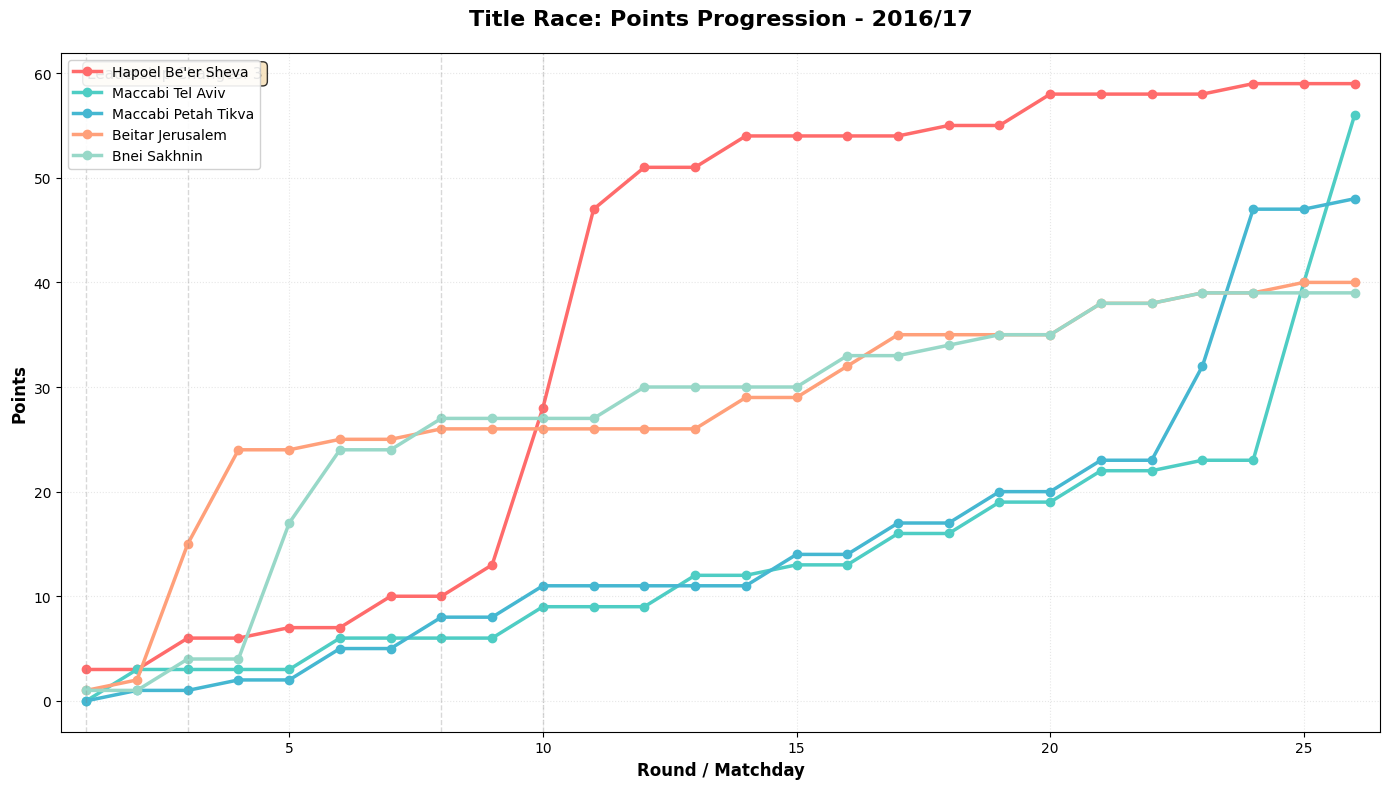

In [15]:
# Visualize the title race - points progression of top teams
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # Use font that supports Hebrew

# Extract points progression for top 5 teams
if 'standings_by_round' in globals() and standings_by_round:
    # Get final top 5 teams
    final_standings = standings_by_round[max(standings_by_round.keys())]
    top_teams = final_standings.head(5)['team'].tolist()
    
    # Build points progression data
    rounds = sorted(standings_by_round.keys())
    progression = {team: [] for team in top_teams}
    
    for round_num in rounds:
        round_standings = standings_by_round[round_num]
        for team in top_teams:
            team_row = round_standings[round_standings['team'] == team]
            if not team_row.empty:
                progression[team].append(team_row.iloc[0]['points'])
            else:
                progression[team].append(0)  # Team not in league yet (shouldn't happen)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each team's progression
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    for idx, team in enumerate(top_teams):
        ax.plot(rounds, progression[team], marker='o', linewidth=2.5, 
                label=team, color=colors[idx], markersize=6)
    
    # Mark leadership changes
    for round_num, leader in leadership_changes:
        if round_num in rounds:
            ax.axvline(x=round_num, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Round / Matchday', fontsize=12, fontweight='bold')
    ax.set_ylabel('Points', fontsize=12, fontweight='bold')
    ax.set_title(f'Title Race: Points Progression - {season}', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper left', framealpha=0.9, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.set_xlim(min(rounds) - 0.5, max(rounds) + 0.5)
    
    # Add annotations for leadership changes
    if len(leadership_changes) > 1:
        ax.text(0.02, 0.98, f'Leadership Changes: {len(leadership_changes) - 1}', 
                transform=ax.transAxes, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    fig_path = FIG_DIR / f'title_race_{season.replace("/", "_")}.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n💾 Saved figure to: {fig_path}")
    
    plt.show()
else:
    print("⚠ Please run the previous cell first to calculate standings_by_round")


### Multi-Season Comparison: Competitive Balance

Compare how competitive each season was by analyzing leadership changes across multiple seasons.


ℹ Processing 2006/07: 132 matches, 12 teams
ℹ Processing 2007/08: 132 matches, 12 teams
ℹ Processing 2008/09: 132 matches, 12 teams
⚠ Error analyzing 2008/09: 'Hapoel Raanana'
ℹ Processing 2009/10: 239 matches, 16 teams
ℹ Processing 2010/11: 234 matches, 16 teams
ℹ Processing 2011/12: 240 matches, 16 teams
ℹ Processing 2010/11: 234 matches, 16 teams
ℹ Processing 2011/12: 240 matches, 16 teams
ℹ Processing 2012/13: 182 matches, 14 teams
ℹ Processing 2013/14: 182 matches, 14 teams
ℹ Processing 2012/13: 182 matches, 14 teams
ℹ Processing 2013/14: 182 matches, 14 teams
ℹ Processing 2014/15: 181 matches, 14 teams
ℹ Processing 2015/16: 182 matches, 14 teams
ℹ Processing 2014/15: 181 matches, 14 teams
ℹ Processing 2015/16: 182 matches, 14 teams
ℹ Processing 2016/17: 182 matches, 14 teams
ℹ Processing 2017/18: 181 matches, 14 teams
ℹ Processing 2016/17: 182 matches, 14 teams
ℹ Processing 2017/18: 181 matches, 14 teams
ℹ Processing 2018/19: 182 matches, 14 teams
ℹ Processing 2019/20: 182 matche

,season,leadership_changes,different_leaders,champion,champion_points,points_gap,rounds
0,2006/07,0,1,Beitar Jerusalem,43,4,22
1,2007/08,0,1,Beitar Jerusalem,51,11,22
2,2009/10,2,3,Maccabi Haifa,77,6,30
3,2010/11,3,4,Maccabi Haifa,70,8,30
4,2011/12,6,6,Ironi Kiryat Shmona,66,13,30
5,2012/13,4,5,Maccabi Tel Aviv,59,10,26
6,2013/14,3,4,Maccabi Tel Aviv,66,7,26
7,2014/15,5,5,Maccabi Tel Aviv,55,6,26
8,2015/16,1,2,Hapoel Be'er Sheva,64,3,26
9,2016/17,3,4,Hapoel Be'er Sheva,59,3,26



📊 Most Competitive Seasons (by leadership changes):
  2011/12: 6 changes, Champion: Ironi Kiryat Shmona (66 pts)
  2018/19: 6 changes, Champion: Maccabi Tel Aviv (66 pts)
  2014/15: 5 changes, Champion: Maccabi Tel Aviv (55 pts)
  2012/13: 4 changes, Champion: Maccabi Tel Aviv (59 pts)
  2010/11: 3 changes, Champion: Maccabi Haifa (70 pts)

🏆 Most Dominant Championships (fewest leadership changes):
  2006/07: 0 changes, Champion: Beitar Jerusalem (4 pts gap)
  2007/08: 0 changes, Champion: Beitar Jerusalem (11 pts gap)
  2021/22: 0 changes, Champion: Maccabi Haifa (4 pts gap)
  2022/23: 0 changes, Champion: Maccabi Haifa (4 pts gap)
  2024/25: 0 changes, Champion: Hapoel Be'er Sheva (5 pts gap)

💾 Saved figure to: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\reports\figures\competitive_balance_all_seasons.png

💾 Saved figure to: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\reports\figures\competitive_balance_all_seasons.png


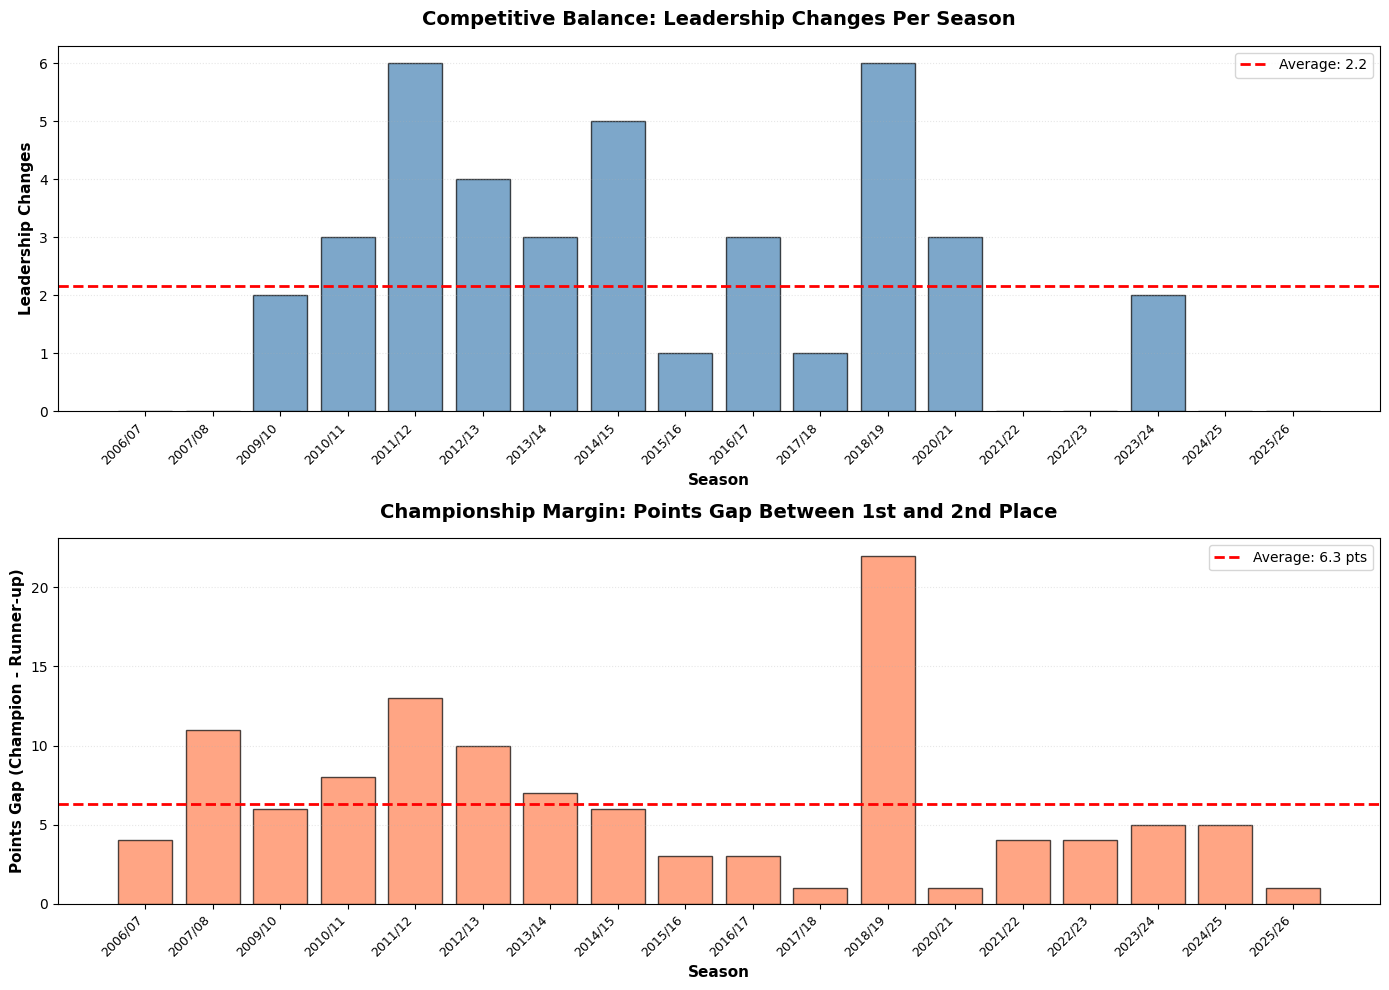

💾 Saved summary to: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\processed\competitive_balance_summary.csv


In [16]:
# Analyze leadership changes across multiple seasons
import pandas as pd

ensure_environment()

# Load all seasons data
matches_path = DATA_DIR / "matches_all_seasons_ligat_haal_wikipedia.csv"

if matches_path.exists():
    all_matches = pd.read_csv(matches_path)
    
    # Normalize team names (convert abbreviations to full names)
    all_matches = normalize_team_names(all_matches, TEAM_NAME_MAP)
    
    # Apply season-specific fixes
    for season_name in all_matches['season'].unique():
        season_data = all_matches[all_matches['season'] == season_name]
        all_matches.loc[all_matches['season'] == season_name] = apply_season_specific_fixes(season_data, season_name)
    
    # Analyze each season
    seasons_to_analyze = sorted(all_matches['season'].unique())
    
    results = []
    for season in seasons_to_analyze:
        try:
            standings_by_round, leadership_changes = calculate_league_table_by_round(all_matches, season)
            
            # Get final standings
            final = standings_by_round[max(standings_by_round.keys())]
            champion = final.iloc[0]['team']
            champion_points = final.iloc[0]['points']
            runner_up_points = final.iloc[1]['points'] if len(final) > 1 else 0
            points_gap = champion_points - runner_up_points
            
            results.append({
                'season': season,
                'leadership_changes': len(leadership_changes) - 1,  # Subtract initial leader
                'different_leaders': len(set([l[1] for l in leadership_changes])),
                'champion': champion,
                'champion_points': champion_points,
                'points_gap': points_gap,
                'rounds': len(standings_by_round)
            })
        except Exception as e:
            print(f"⚠ Error analyzing {season}: {e}")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(results)
    summary_df = summary_df.sort_values('season')
    
    print("🏆 COMPETITIVE BALANCE ANALYSIS - ALL SEASONS")
    print("=" * 80)
    display(summary_df)
    
    # Identify most competitive seasons
    print("\n📊 Most Competitive Seasons (by leadership changes):")
    top_competitive = summary_df.nlargest(5, 'leadership_changes')
    for idx, row in top_competitive.iterrows():
        print(f"  {row['season']}: {int(row['leadership_changes'])} changes, "
              f"Champion: {row['champion']} ({int(row['champion_points'])} pts)")
    
    print("\n🏆 Most Dominant Championships (fewest leadership changes):")
    least_competitive = summary_df.nsmallest(5, 'leadership_changes')
    for idx, row in least_competitive.iterrows():
        print(f"  {row['season']}: {int(row['leadership_changes'])} changes, "
              f"Champion: {row['champion']} ({int(row['points_gap'])} pts gap)")
    
    # Visualization: Leadership changes over time
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Leadership changes per season
    ax1.bar(range(len(summary_df)), summary_df['leadership_changes'], 
            color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Season', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Leadership Changes', fontsize=11, fontweight='bold')
    ax1.set_title('Competitive Balance: Leadership Changes Per Season', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.set_xticks(range(len(summary_df)))
    ax1.set_xticklabels(summary_df['season'], rotation=45, ha='right', fontsize=9)
    ax1.grid(axis='y', alpha=0.3, linestyle=':')
    ax1.axhline(y=summary_df['leadership_changes'].mean(), 
                color='red', linestyle='--', linewidth=2, 
                label=f'Average: {summary_df["leadership_changes"].mean():.1f}')
    ax1.legend()
    
    # Plot 2: Points gap (champion vs runner-up)
    ax2.bar(range(len(summary_df)), summary_df['points_gap'], 
            color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Season', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Points Gap (Champion - Runner-up)', fontsize=11, fontweight='bold')
    ax2.set_title('Championship Margin: Points Gap Between 1st and 2nd Place', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xticks(range(len(summary_df)))
    ax2.set_xticklabels(summary_df['season'], rotation=45, ha='right', fontsize=9)
    ax2.grid(axis='y', alpha=0.3, linestyle=':')
    ax2.axhline(y=summary_df['points_gap'].mean(), 
                color='red', linestyle='--', linewidth=2, 
                label=f'Average: {summary_df["points_gap"].mean():.1f} pts')
    ax2.legend()
    
    plt.tight_layout()
    
    # Save figure
    fig_path = FIG_DIR / 'competitive_balance_all_seasons.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n💾 Saved figure to: {fig_path}")
    
    plt.show()
    
    # Save summary to CSV
    summary_path = PROCESSED_DIR / 'competitive_balance_summary.csv'
    summary_df.to_csv(summary_path, index=False, encoding='utf-8-sig')
    print(f"💾 Saved summary to: {summary_path}")
    
else:
    print(f"❌ File not found: {matches_path}")
    print("Please run the multi-season Wikipedia scraper first")

## Analysis 2: Multi-Season Attendance Collection

Scrape attendance data from Transfermarkt for all 20 seasons to enable trend analysis.


In [17]:
# Scrape attendance data for multiple seasons from Transfermarkt
import pandas as pd
import time
from datetime import datetime

ensure_environment()

# Calculate seasons to scrape (last 20 seasons)
current_year = datetime.now().year
if datetime.now().month < 8:  # If before August, last season started in previous year
    current_year -= 1
seasons_to_scrape = list(range(current_year - 19, current_year + 1))

print(f"Scraping attendance data for {len(seasons_to_scrape)} seasons from Transfermarkt...")
print(f"Seasons: {seasons_to_scrape[0]}/{str(seasons_to_scrape[0]+1)[-2:]} to {seasons_to_scrape[-1]}/{str(seasons_to_scrape[-1]+1)[-2:]}")
print("=" * 80)

all_attendance = []
success_count = 0
fail_count = 0

for season_year in seasons_to_scrape:
    # Check if already scraped
    existing_file = DATA_DIR / f"attendance_{season_year}_{str(season_year+1)[-2:]}_ligat_haal_transfermarkt.csv"
    
    if existing_file.exists():
        print(f"{season_year}/{str(season_year+1)[-2:]}: ⏭ (already exists, loading...)")
        try:
            df = pd.read_csv(existing_file)
            all_attendance.append(df)
            success_count += 1
        except Exception as e:
            print(f"   ⚠ Error loading existing file: {e}")
            fail_count += 1
    else:
        # Scrape new season
        df = scrape_transfermarkt_attendance(season_year)
        
        if df is not None and len(df) > 0:
            all_attendance.append(df)
            success_count += 1
            time.sleep(2)  # Be polite to Transfermarkt
        else:
            fail_count += 1
        
        time.sleep(1)  # Rate limiting

print("\n" + "=" * 80)
print(f"✅ Successfully collected: {success_count} seasons")
print(f"❌ Failed: {fail_count} seasons")

if all_attendance:
    # Combine all seasons
    combined_attendance = pd.concat(all_attendance, ignore_index=True)
    
    # Save combined file
    combined_path = DATA_DIR / "attendance_all_seasons_ligat_haal_transfermarkt.csv"
    save_csv(combined_attendance, combined_path)
    
    print(f"\n📊 Combined Attendance Data:")
    print(f"  • Total rows: {len(combined_attendance)}")
    print(f"  • Seasons: {combined_attendance['season'].nunique()}")
    print(f"  • Unique teams: {combined_attendance['team'].nunique()}")
    
    # Show sample
    display(combined_attendance.head(10))
    
    # Summary statistics by season
    print("\n📈 Average Attendance by Season:")
    season_avg = combined_attendance.groupby('season').agg({
        'average_attendance': 'mean',
        'utilization_pct': 'mean',
        'team': 'count'
    }).round(0)
    season_avg.columns = ['Avg Attendance', 'Avg Utilization %', 'Teams']
    display(season_avg)
else:
    print("\n⚠ No attendance data was successfully collected.")


Scraping attendance data for 20 seasons from Transfermarkt...
Seasons: 2006/07 to 2025/26
Fetching 2006/07 from Transfermarkt... ✓ (12 teams)
✓ (12 teams)
Fetching 2007/08 from Transfermarkt... Fetching 2007/08 from Transfermarkt... ✓ (12 teams)
✓ (12 teams)
Fetching 2008/09 from Transfermarkt... Fetching 2008/09 from Transfermarkt... ✓ (12 teams)
✓ (12 teams)
Fetching 2009/10 from Transfermarkt... Fetching 2009/10 from Transfermarkt... ✓ (16 teams)
✓ (16 teams)
Fetching 2010/11 from Transfermarkt... Fetching 2010/11 from Transfermarkt... ✓ (16 teams)
✓ (16 teams)
Fetching 2011/12 from Transfermarkt... Fetching 2011/12 from Transfermarkt... ✓ (16 teams)
✓ (16 teams)
Fetching 2012/13 from Transfermarkt... Fetching 2012/13 from Transfermarkt... ✓ (14 teams)
✓ (14 teams)
Fetching 2013/14 from Transfermarkt... Fetching 2013/14 from Transfermarkt... ✓ (14 teams)
✓ (14 teams)
Fetching 2014/15 from Transfermarkt... Fetching 2014/15 from Transfermarkt... ✓ (14 teams)
✓ (14 teams)
Fetching 2015

,season,season_year,team,average_attendance,total_attendance,stadium_capacity,utilization_pct
0,2006/07,2006,Bnei Yehuda Tel Aviv,3063,49000,6020,50.9
1,2006/07,2006,Hapoel Tel Aviv,5333,16000,29150,18.3
2,2006/07,2006,Hapoel Petah Tikva,2050,10250,11500,17.8
3,2006/07,2006,Beitar Jerusalem,10000,10000,33500,29.9
4,2006/07,2006,Maccabi Netanya,3083,9250,13610,22.7
5,2006/07,2006,Maccabi Haifa,3850,7700,30780,12.5
6,2006/07,2006,Hakoah Amidar Ramat Gan,1250,6250,8000,15.6
7,2006/07,2006,Hapoel Kfar Saba,2250,4500,5800,38.8
8,2006/07,2006,FC Ashdod,2500,2500,8200,30.5
9,2006/07,2006,Maccabi Petah Tikva,2000,2000,11500,17.4



📈 Average Attendance by Season:


,Avg Attendance,Avg Utilization %,Teams
season,,,
2006/07,3136.0,22.0,12
2007/08,5738.0,37.0,12
2008/09,0.0,0.0,12
2009/10,3926.0,24.0,16
2010/11,4867.0,28.0,16
2011/12,3891.0,27.0,16
2012/13,5038.0,31.0,14
2013/14,5444.0,37.0,14
2014/15,7630.0,43.0,14


In [18]:
print(DATA_DIR.resolve())


C:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\data\raw


---

# 🗺️ PROJECT ROADMAP & RECOMMENDATIONS

## ✅ What You Have Now

### Data Sources:
1. **Wikipedia Match Data** (✓ Complete):
   - 20 seasons of match-by-match results (2006/07 to 2025/26)
   - ~182 matches per season
   - Columns: season, home_team, away_team, home_goals, away_goals, result, points

2. **Transfermarkt Attendance** (Partial):
   - Only 2016/17 and 2023/24 currently scraped
   - Data: average attendance, total attendance, stadium capacity, utilization %

### Enriched Data:
- Match results with calculated metrics (goal_diff, points, one_sided flags)
- League standings calculator function (in memory)

---

## 📊 ANSWER TO YOUR QUESTION

### "Can we track first-place changes using Transfermarkt data?"

**NO - but YES with Wikipedia data!**

**Why Transfermarkt alone won't work:**
- Transfermarkt provides: Attendance stats (avg fans, capacity, utilization)
- Transfermarkt does NOT provide: Match results or standings progression

**The Solution:**
✅ Use **Wikipedia match data** (which you already have!) to calculate:
1. League table after each matchday
2. Track which team was #1 after each round
3. Count leadership changes

**Status:** ✅ IMPLEMENTED! (See cells above)
- Function: `calculate_league_table_by_round()`
- Output: Leadership changes per season + visualization

---

## 🎯 RECOMMENDED NEXT STEPS

### Priority 1: Fix Team Names (CRITICAL for merging data)
**Problem:** Wikipedia uses abbreviated names (BEI, HBS, MTA) vs full names
**Solution:** Create a team name mapping dictionary
**Benefit:** Enable joining attendance data with match results

```python
team_name_map = {
    'HBS': 'Hapoel Be\'er Sheva',
    'MTA': 'Maccabi Tel Aviv',
    'BEI': 'Beitar Jerusalem',
    # ... etc
}
```

### Priority 2: Multi-Season Attendance Scraping
**Action:** Run cell 29 (Multi-Season Attendance Collection)
**Result:** Attendance data for all 20 seasons
**Time:** ~5-10 minutes (with rate limiting)

### Priority 3: Advanced Analyses

#### A) **Championship Race Intensity**
- Track points gap between 1st and 2nd place over time
- Identify closest title races
- Visualize: Line chart of top 5 teams' points progression

#### B) **Home Advantage Analysis**
- Calculate home win % vs away win %
- Correlate with attendance levels
- Question: Do full stadiums boost home performance?

#### C) **Derby Match Analysis**
- Identify derby matches (e.g., Beitar vs Maccabi Tel Aviv)
- Compare attendance at derbies vs regular matches
- Analyze: Are derbies more competitive (closer scores)?

#### D) **Relegation Battle Tracker**
- Track bottom 3 teams' points progression
- Identify seasons with closest relegation fights
- Compare with championship race intensity

#### E) **Attendance Trends**
- Plot average attendance over 20 years
- Correlate with team performance (winning teams = more fans?)
- Identify: Which teams have most loyal fanbases (high % even when losing)?

---

## 🛠️ IMMEDIATE ACTION ITEMS

### Step 1: Normalize Team Names
Create a mapping cell to standardize names across sources

### Step 2: Scrape Multi-Season Attendance
Run the attendance scraper for all seasons (currently only have 2)

### Step 3: Merge Datasets
Join attendance + match results by (season, team)

### Step 4: Build Analysis Dashboard
Create cells for each analysis type above

---

## 📁 FINAL DATA STRUCTURE (Target)

```
data/processed/
├── matches_with_attendance.csv      # Main analysis file
├── competitive_balance_summary.csv  # Leadership changes per season
├── attendance_trends.csv            # Average attendance over time
├── team_performance_summary.csv     # Win%, avg attendance by team/season
└── derby_matches_analysis.csv       # Special rivalry matches
```

---

## 💡 KEY INSIGHTS YOU CAN ANSWER

After completing the roadmap:

1. **Which season had the most competitive title race?**
   - Already partially implemented! (leadership changes tracker)

2. **Do winning teams attract more fans?**
   - Requires: Merging attendance + standings

3. **What's the "home advantage" value in Ligat Ha'al?**
   - Calculate: Home win % - Away win %

4. **Which teams have the most loyal fanbases?**
   - Metric: Attendance consistency regardless of league position

5. **How has league competitiveness changed over 20 years?**
   - Track: Points gaps, leadership changes trend

---

## ⚡ QUICK START COMMAND

To get the full dataset ready for analysis, run these cells in order:

1. **Cell 5** - Environment Setup
2. **Cell 6** - Shared Utilities
3. **Cell 17** - Multi-Season Match Scraper (if not done)
4. **Cell 29** - Multi-Season Attendance Scraper ← **DO THIS NEXT!**
5. **Cell 24** - Leadership Changes Analysis ← **ALREADY WORKS!**

Then you'll have everything needed for the advanced analyses above.

---
